### Problem: Time Series Anomaly Detection

#### Technique: LSTM Prediction

Language: Python

Library: Keras

Data at Kaggle: https://www.kaggle.com/boltzmannbrain/nab

Source: https://github.com/Vicam/Unsupervised_Anomaly_Detection/blob/master/Anomaly%20detection%2C%20different%20methods%20on%20a%20simple%20example.ipynb

Use for sequential anomalies (ordered)

RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.
Here we make learn from 50 previous values, and we predict just the 1 next value.

In [77]:
# libraries
%matplotlib notebook

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing

In [2]:
BASE = 'D:\\ResearchDataGtx1060\\AnomalyDetectionData\\'

fname = 'ambient_temperature_system_failure.csv'

In [3]:
df = pd.read_csv(BASE+fname)
df.head(5)

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


### Understand data

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [5]:
# check the timestamp format and frequence 
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [6]:
# check the temperature mean
print(df['value'].mean())

71.2424327082882


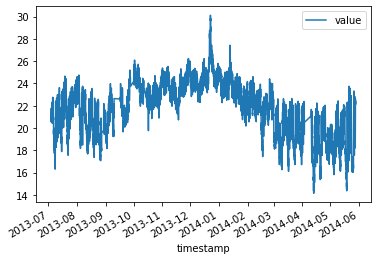

In [7]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

### Feature engineering
Extracting some useful features

In [9]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [15]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [11]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

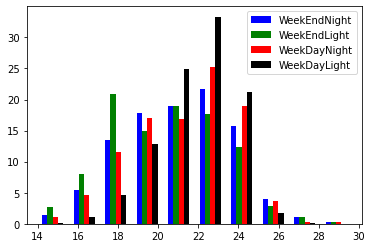

In [17]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

### Model

In [19]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)
data_n.head(5)

,0,1,2,3,4
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132


In [20]:
# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

In [24]:
#train data
x_train = data_n[0:-prediction_time-testdatacut]
y_train = data_n[prediction_time:-testdatacut][0]

In [41]:
# test data
x_test = data_n[0-testdatacut:-prediction_time]
y_test = data_n[prediction_time-testdatacut:][0]

In [43]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [44]:
# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [52]:
# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [53]:
# specific libraries for LSTM
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import model_from_json

In [56]:
x_train.shape[-3]

6165

In [59]:
# Build the model
model = Sequential()

model.add(LSTM(input_dim=x_train.shape[-1],units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

#start = time.time()
model.compile(loss='mse', optimizer='rmsprop')

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 50)          11200     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 71,701
Trainable params: 71,701
Non-trainable params: 0
__________________________________________________

In [61]:
# Train the model
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    epochs=350,
    validation_split=0.1)

Epoch 1/350
2/2 [==============================] - 2s 843ms/step - loss: 0.5120 - val_loss: 0.5130
Epoch 2/350
2/2 [==============================] - 0s 162ms/step - loss: 0.1704 - val_loss: 0.3292
Epoch 3/350
2/2 [==============================] - 0s 157ms/step - loss: 0.1607 - val_loss: 0.3075
Epoch 4/350
2/2 [==============================] - 0s 163ms/step - loss: 0.1138 - val_loss: 0.2614
Epoch 5/350
2/2 [==============================] - 0s 225ms/step - loss: 0.1047 - val_loss: 0.2452
Epoch 6/350
2/2 [==============================] - 0s 159ms/step - loss: 0.1021 - val_loss: 0.2198
Epoch 7/350
2/2 [==============================] - 0s 156ms/step - loss: 0.0974 - val_loss: 0.1988
Epoch 8/350
2/2 [==============================] - 0s 167ms/step - loss: 0.0945 - val_loss: 0.1861
Epoch 9/350
2/2 [==============================] - 0s 160ms/step - loss: 0.0898 - val_loss: 0.1576
Epoch 10/350
2/2 [==============================] - 0s 162ms/step - loss: 0.0828 - val_loss: 0.1438
Epoch 11/

2/2 [==============================] - 0s 166ms/step - loss: 0.0508 - val_loss: 0.0855
Epoch 84/350
2/2 [==============================] - 0s 157ms/step - loss: 0.0525 - val_loss: 0.0870
Epoch 85/350
2/2 [==============================] - 0s 166ms/step - loss: 0.0551 - val_loss: 0.0999
Epoch 86/350
2/2 [==============================] - 0s 166ms/step - loss: 0.0584 - val_loss: 0.0962
Epoch 87/350
2/2 [==============================] - 0s 154ms/step - loss: 0.0556 - val_loss: 0.0947
Epoch 88/350
2/2 [==============================] - 0s 232ms/step - loss: 0.0514 - val_loss: 0.0807
Epoch 89/350
2/2 [==============================] - 1s 273ms/step - loss: 0.0502 - val_loss: 0.0987
Epoch 90/350
2/2 [==============================] - 1s 268ms/step - loss: 0.0519 - val_loss: 0.0960
Epoch 91/350
2/2 [==============================] - 1s 322ms/step - loss: 0.0517 - val_loss: 0.0877
Epoch 92/350
2/2 [==============================] - 1s 329ms/step - loss: 0.0504 - val_loss: 0.1012
Epoch 93/350


2/2 [==============================] - 1s 272ms/step - loss: 0.0483 - val_loss: 0.0804
Epoch 165/350
2/2 [==============================] - 1s 281ms/step - loss: 0.0476 - val_loss: 0.0761
Epoch 166/350
2/2 [==============================] - 1s 288ms/step - loss: 0.0459 - val_loss: 0.0771
Epoch 167/350
2/2 [==============================] - 1s 307ms/step - loss: 0.0455 - val_loss: 0.0837
Epoch 168/350
2/2 [==============================] - 1s 286ms/step - loss: 0.0439 - val_loss: 0.0800
Epoch 169/350
2/2 [==============================] - 1s 285ms/step - loss: 0.0446 - val_loss: 0.0904
Epoch 170/350
2/2 [==============================] - 1s 313ms/step - loss: 0.0463 - val_loss: 0.0836
Epoch 171/350
2/2 [==============================] - 1s 314ms/step - loss: 0.0475 - val_loss: 0.0834
Epoch 172/350
2/2 [==============================] - 1s 327ms/step - loss: 0.0482 - val_loss: 0.0946
Epoch 173/350
2/2 [==============================] - 1s 291ms/step - loss: 0.0486 - val_loss: 0.0755
Epoc

2/2 [==============================] - 1s 320ms/step - loss: 0.0424 - val_loss: 0.0802
Epoch 246/350
2/2 [==============================] - 1s 274ms/step - loss: 0.0420 - val_loss: 0.0860
Epoch 247/350
2/2 [==============================] - 1s 283ms/step - loss: 0.0414 - val_loss: 0.0861
Epoch 248/350
2/2 [==============================] - 1s 274ms/step - loss: 0.0416 - val_loss: 0.0854
Epoch 249/350
2/2 [==============================] - 1s 290ms/step - loss: 0.0412 - val_loss: 0.0881
Epoch 250/350
2/2 [==============================] - 1s 282ms/step - loss: 0.0421 - val_loss: 0.0945
Epoch 251/350
2/2 [==============================] - 1s 273ms/step - loss: 0.0490 - val_loss: 0.0858
Epoch 252/350
2/2 [==============================] - 1s 322ms/step - loss: 0.0474 - val_loss: 0.0761
Epoch 253/350
2/2 [==============================] - 1s 289ms/step - loss: 0.0415 - val_loss: 0.0788
Epoch 254/350
2/2 [==============================] - 1s 283ms/step - loss: 0.0414 - val_loss: 0.0823
Epoc

2/2 [==============================] - 0s 240ms/step - loss: 0.0407 - val_loss: 0.0746
Epoch 327/350
2/2 [==============================] - 1s 288ms/step - loss: 0.0426 - val_loss: 0.0727
Epoch 328/350
2/2 [==============================] - 1s 283ms/step - loss: 0.0408 - val_loss: 0.0752
Epoch 329/350
2/2 [==============================] - 1s 282ms/step - loss: 0.0412 - val_loss: 0.0766
Epoch 330/350
2/2 [==============================] - 1s 290ms/step - loss: 0.0398 - val_loss: 0.0741
Epoch 331/350
2/2 [==============================] - 1s 291ms/step - loss: 0.0414 - val_loss: 0.0763
Epoch 332/350
2/2 [==============================] - 1s 287ms/step - loss: 0.0441 - val_loss: 0.0740
Epoch 333/350
2/2 [==============================] - 1s 312ms/step - loss: 0.0426 - val_loss: 0.0731
Epoch 334/350
2/2 [==============================] - 1s 287ms/step - loss: 0.0413 - val_loss: 0.0752
Epoch 335/350
2/2 [==============================] - 1s 332ms/step - loss: 0.0416 - val_loss: 0.0698
Epoc

In [62]:
# create the list of difference between prediction and test data
diff=[]
ratio=[]
y_test = y_test.values
p = model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

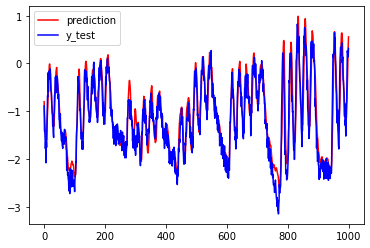

In [64]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [65]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

In [67]:
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)

In [72]:
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))

In [75]:
## add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


<IPython.core.display.Javascript object>


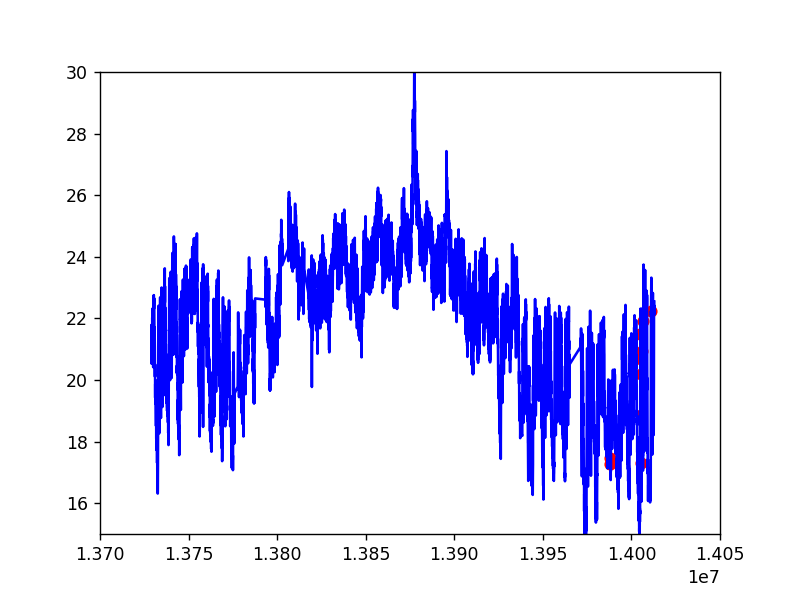

In [78]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

<IPython.core.display.Javascript object>


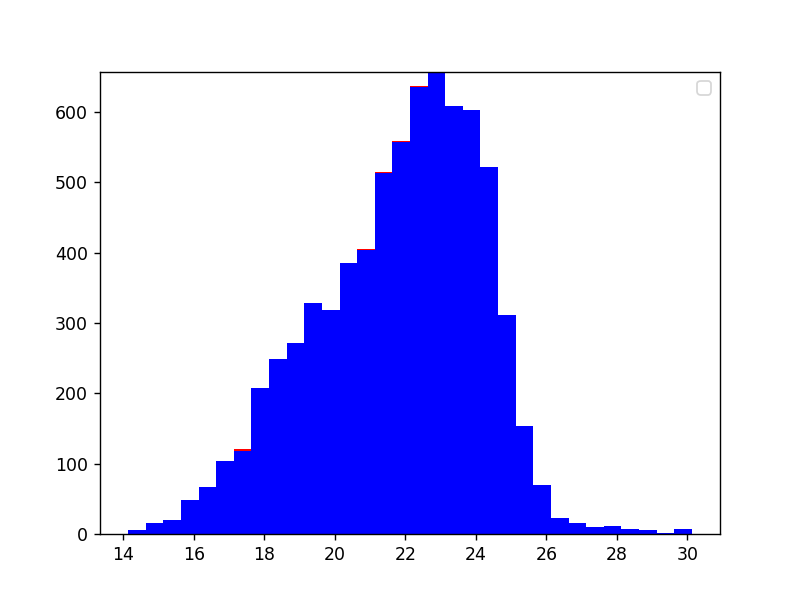

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [79]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()